In [95]:
using Random
using SSM
using Distributions
using Plots
using StatsBase

In [2]:
Threads.nthreads()

8

In [113]:
# generate data from a "switching gaussian regression"
n = 100
K = 2

A = [0.8 0.2; 0.2 0.8]
β₁ = exp.(LinRange(-10, 0, 50)) ./ (sum(exp.(LinRange(-10, 0, 50)) * mean(diff(LinRange(-10, 0, 50)))))
β₂ = exp.(LinRange(-4, 0, 50)) ./ (sum(exp.(LinRange(-4, 0, 50)) * mean(diff(LinRange(-4, 0, 50)))))
σ²₁, σ²₂ = 1.0, 1.0;

In [142]:
R = 100

100

In [143]:
X = Array{Matrix{Float64}}(undef, R)
S = Array{Vector{Float64}}(undef, R)
Y = Array{Vector{Float64}}(undef, R);


In [144]:
for ii = 1:R

    x = cat(zeros(50), randn(n, 1), dims=1);
    XX = permutedims(hcat([x[i:i+50-1] for i in 1:n]...), (2,1))
    YY = zeros(n)
    SS = zeros(Int, n)

    for i in 1:n

        if i == 1
            SS[i] = StatsBase.sample(1:K, Weights([0.5, 0.5]))
        else
            SS[i] = StatsBase.sample(1:K, Weights(A[SS[i-1], :]))
        end

        if SS[i] == 1
            YY[i] = XX[i, :]'*β₁ + rand(Normal(0, sqrt(σ²₁)))
        elseif SS[i] == 2
            YY[i] = XX[i, :]'*β₂ + rand(Normal(0, sqrt(σ²₂)))
        end
    end

    X[ii] = XX;
    Y[ii] = YY;
    S[ii] = SS;

end

In [171]:
mean(map(S-> S[1], S))

1.54

In [145]:
model = SwitchingGaussianRegression(;K=2, λ=1e-2)

SwitchingGaussianRegression{Float64}([0.30190128589426224 0.6980987141057378; 0.35909092180565916 0.6409090781943408], RegressionEmissions[RegressionEmissions(GaussianRegression(Float64[], 0.0, true, 0.01)), RegressionEmissions(GaussianRegression(Float64[], 0.0, true, 0.01))], [0.23490273934547642, 0.7650972606545235], 2, 0.01)

In [146]:
ll = SSM.fit!(model, X, Y, 2000, 1e-6, true);

Log-Likelihood at iter 1: -150306.8697383928
Log-Likelihood at iter 2: -15885.554700140412
Log-Likelihood at iter 3: -15742.523123486657
Log-Likelihood at iter 4: -15734.64074811235
Log-Likelihood at iter 5: -15728.598423215852
Log-Likelihood at iter 6: -15722.882491980758
Log-Likelihood at iter 7: -15716.881831999954
Log-Likelihood at iter 8: -15709.990028874045
Log-Likelihood at iter 9: -15701.462850058731
Log-Likelihood at iter 10: -15690.303803564202
Log-Likelihood at iter 11: -15675.200273647226
Log-Likelihood at iter 12: -15654.619472314327
Log-Likelihood at iter 13: -15627.167598363794
Log-Likelihood at iter 14: -15591.977967767816
Log-Likelihood at iter 15: -15548.941467338098
Log-Likelihood at iter 16: -15500.07839967436
Log-Likelihood at iter 17: -15450.47341053973
Log-Likelihood at iter 18: -15405.348739921994
Log-Likelihood at iter 19: -15367.89639741419
Log-Likelihood at iter 20: -15338.98321337165
Log-Likelihood at iter 21: -15317.424503942584
Log-Likelihood at iter 22: -

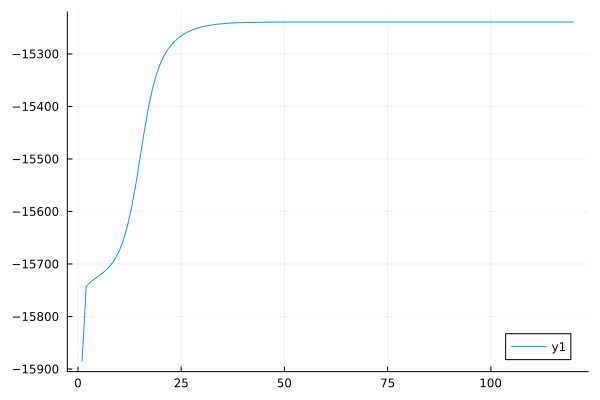

In [147]:
plot(ll[3:end])

In [148]:
model.πₖ

2-element Vector{Float64}:
 0.9999999967605788
 3.2394085827547695e-9

In [149]:
output = SSM.E_step.(Ref(model), X, Y)
γ = map(x-> x[1], output);

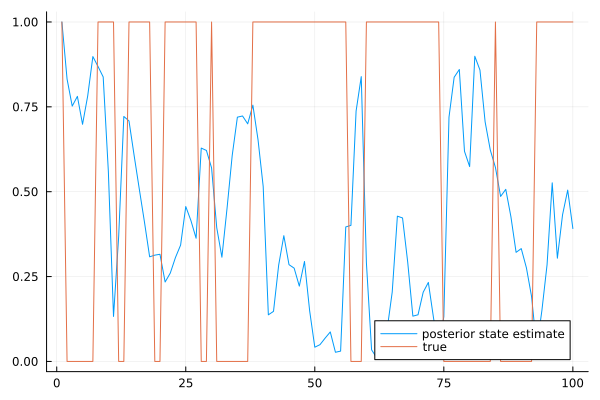

In [150]:
plot(exp.(γ[1])[:,1], label="posterior state estimate")
plot!(S[1] .- 1, label="true")

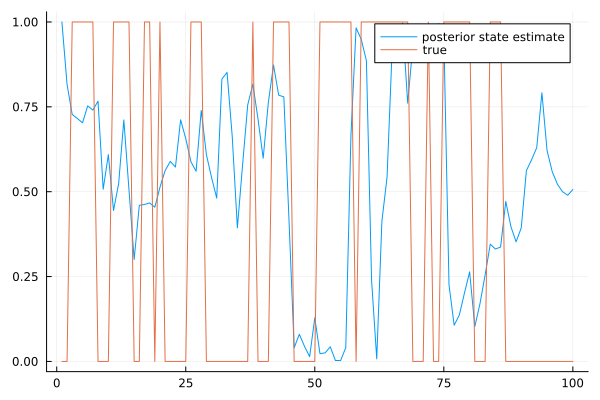

In [156]:
plot(exp.(γ[5])[:,1], label="posterior state estimate")
plot!(S[4] .- 1, label="true")

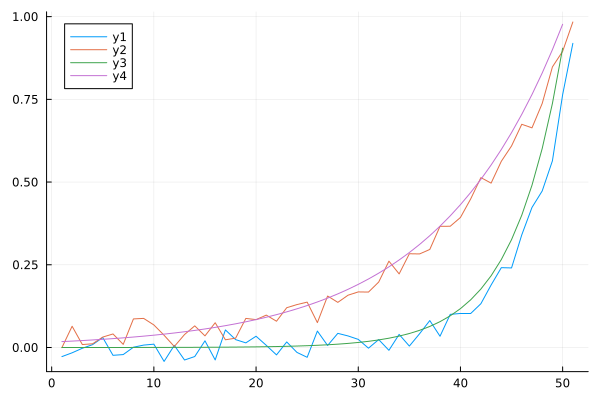

In [167]:
plot(model.B[1].regression.β)
plot!(model.B[2].regression.β)
plot!(β₁)
plot!(β₂)

In [168]:
model.A

2×2 Matrix{Float64}:
 0.79323   0.196274
 0.197471  0.793255